In [14]:
#STEP 0 — Install Required Libraries
!pip install pandas networkx matplotlib groq


In [17]:
#STEP 1 — Import Libraries & Initialize GROQ LLM
from groq import Groq
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

GROQ_API_KEY = " "
client = Groq(api_key=GROQ_API_KEY)

# Test
resp = client.chat.completions.create(
    model="llama-3.1-8b-instant",
    messages=[{"role":"user","content":"Say hello"}]
)
print(resp.choices[0].message.content)


Hello. How can I help you today?


In [18]:
#STEP 2 — Create Dummy Competitor Database
data = [
    [1,"Zara","Koramangala","Bangalore","Multi-brand",10,22,480,18,21,1.4,4.4,3500],
    [2,"H&M","Koramangala","Bangalore","Multi-brand",11,23,520,17,21,1.5,4.5,4000],
    [3,"Reliance Trends","Koramangala","Bangalore","Multi-brand",10,22,430,18,20,1.3,4.1,3000],
    [4,"Westside","Koramangala","Bangalore","Multi-brand",10,22,390,17,20,1.2,4.2,2800],
    [5,"Allen Solly","Koramangala","Bangalore","Men",10,21,260,18,20,1.3,4.0,1800],
    [6,"Levis","Koramangala","Bangalore","Men",11,22,240,18,21,1.4,4.3,1600],
    [7,"Biba","Koramangala","Bangalore","Women",10,21,220,17,20,1.3,4.1,1500],
    [8,"Global Desi","Koramangala","Bangalore","Women",11,22,210,18,21,1.4,4.0,1400],
    [9,"Max Fashion","Koramangala","Bangalore","Budget",10,22,560,17,21,1.6,4.2,4200],
    [10,"Zudio","Koramangala","Bangalore","Budget",10,22,600,17,21,1.7,4.3,4500]
]

columns = ["store_id","store_name","area","city","category","open_time","close_time",
           "avg_daily_footfall","peak_start","peak_end","weekend_multiplier","rating","store_size_sqft"]

df = pd.DataFrame(data, columns=columns)
df.head()


,store_id,store_name,area,city,category,open_time,close_time,avg_daily_footfall,peak_start,peak_end,weekend_multiplier,rating,store_size_sqft
0,1,Zara,Koramangala,Bangalore,Multi-brand,10,22,480,18,21,1.4,4.4,3500
1,2,H&M,Koramangala,Bangalore,Multi-brand,11,23,520,17,21,1.5,4.5,4000
2,3,Reliance Trends,Koramangala,Bangalore,Multi-brand,10,22,430,18,20,1.3,4.1,3000
3,4,Westside,Koramangala,Bangalore,Multi-brand,10,22,390,17,20,1.2,4.2,2800
4,5,Allen Solly,Koramangala,Bangalore,Men,10,21,260,18,20,1.3,4.0,1800


In [19]:
#STEP 3 — Tool Decorator (Agent Tooling)
def tool(func):
    func.is_tool = True
    return func



In [20]:
#STEP 4 — Define Multi-Agent Tools
@tool
def search_store_tool(area, city):
    return df[(df["area"] == area) & (df["city"] == city)]

def search_agent(area, city):
    return search_store_tool(area, city)



In [21]:
#Footfall Analysis Agent
@tool
def footfall_analysis_tool(data):
    avg_footfall = data["avg_daily_footfall"].mean()
    peak_hours = data[["store_name","peak_start","peak_end"]]
    return {
        "avg_footfall": avg_footfall,
        "peak_hours": peak_hours
    }

def footfall_agent(data):
    return footfall_analysis_tool(data)



In [22]:
#Competitor Analysis Agent
@tool
def competitor_analysis_tool(data):
    store_count = len(data)
    density = "High" if store_count > 7 else "Moderate"
    return {
        "store_count": store_count,
        "market_density": density
    }

def competitor_agent(data):
    return competitor_analysis_tool(data)



In [28]:
#Report Agent (Groq LLM)
@tool
def report_generation_tool(area, footfall_info, competition_info):
    table_str = footfall_info["peak_hours"].to_string(index=False)

    prompt = f"""
You are a retail business consultant.

Create a professional competitor analysis report for opening a new clothing store in {area}, Bangalore.

Data Summary:
- Average Daily Footfall: {footfall_info["avg_footfall"]}
- Competitor Count: {competition_info["store_count"]}
- Market Density: {competition_info["market_density"]}

Peak Hour Details:
{table_str}

Structure:
1. Market Overview
2. Competitor Landscape
3. Customer Traffic Patterns
4. Strategic Recommendations
5. Business Opportunities
"""

    response = client.chat.completions.create(
        model="llama-3.1-8b-instant",
        messages=[
            {"role": "system", "content": "You are a senior business analyst."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message.content

def report_agent(area, footfall_info, competition_info):
    return report_generation_tool(area, footfall_info, competition_info)


In [29]:
#STEP 5 — Simple LangGraph-Style Node
class AgentNode:
    def __init__(self, name, agent_func):
        self.name = name
        self.agent_func = agent_func

    def run(self, *args):
        return self.agent_func(*args)


In [30]:
#STEP 6 — Build Pipeline
search_node = AgentNode("Search Agent", lambda: search_agent("Koramangala", "Bangalore"))
footfall_node = AgentNode("Footfall Agent", lambda data: footfall_agent(data))
competitor_node = AgentNode("Competitor Agent", lambda data: competitor_agent(data))
report_node = AgentNode("Report Agent", lambda footfall_info, competition_info:
                         report_agent("Koramangala", footfall_info, competition_info))


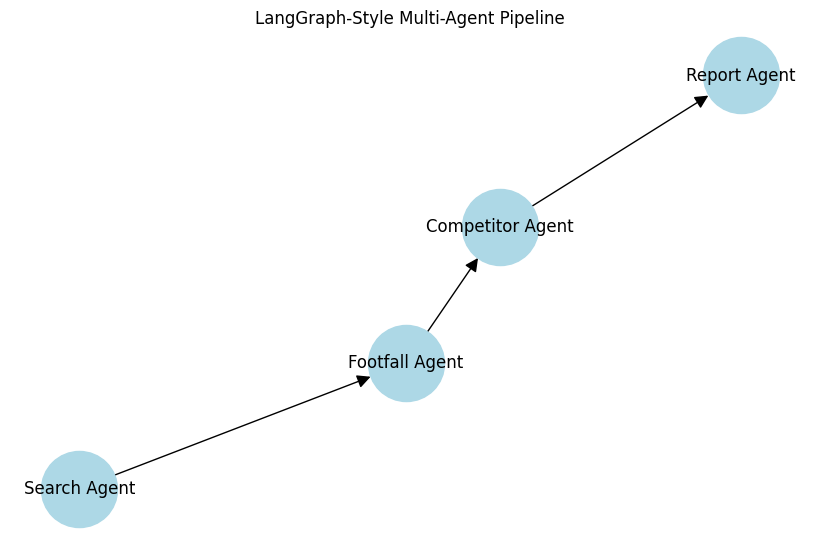

In [31]:
#STEP 7 — Visualize Pipeline
G = nx.DiGraph()
G.add_edges_from([
    ("Search Agent","Footfall Agent"),
    ("Footfall Agent","Competitor Agent"),
    ("Competitor Agent","Report Agent")
])

plt.figure(figsize=(8,5))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=3000, arrowsize=20)
plt.title("LangGraph-Style Multi-Agent Pipeline")
plt.show()


In [32]:
# Step 1: Search
search_results = search_node.run()

# Step 2: Footfall
footfall_info = footfall_node.run(search_results)

# Step 3: Competitor
competition_info = competitor_node.run(search_results)

# Step 4: Report (LLM)
final_report = report_node.run(footfall_info, competition_info)

print(final_report)


**Competition Analysis Report: New Clothing Store in Koramangala, Bangalore**

**1. Market Overview**

Koramangala, Bangalore is a bustling commercial and retail hub with a high population density. The area is a hotspot for young professionals, students, and tourists, creating a demand for trendy and affordable clothing. The area's high footfall and dense competition necessitate a well-planned retail strategy to stand out from the crowd. With an average daily footfall of 391.0, Koramangala presents a significant business opportunity for a new clothing store.

**2. Competitor Landscape**

There are 10 established clothing stores in the Koramangala area, including:

* Zara
* H&M
* Reliance Trends
* Westside
* Allen Solly
* Levis
* Biba
* Global Desi
* Max Fashion
* Zudio

This competitor count indicates a highly saturated market, making it essential to differentiate the new store through unique offerings, pricing, and experience.

**Comparative Analysis of Competitors:**

| Store Name | 

In [33]:
# SECOND QUERY — Different Area

search_node_2 = AgentNode("Search Agent", lambda: search_agent("Koramangala", "Bangalore"))
footfall_node_2 = AgentNode("Footfall Agent", lambda data: footfall_agent(data))
competitor_node_2 = AgentNode("Competitor Agent", lambda data: competitor_agent(data))
report_node_2 = AgentNode(
    "Report Agent",
    lambda footfall_info, competition_info: report_agent("Koramangala", footfall_info, competition_info)
)

# Execute again
search_results_2 = search_node_2.run()
footfall_info_2 = footfall_node_2.run(search_results_2)
competition_info_2 = competitor_node_2.run(search_results_2)
final_report_2 = report_node_2.run(footfall_info_2, competition_info_2)

print("===== SECOND QUERY OUTPUT =====\n")
print(final_report_2)


===== SECOND QUERY OUTPUT =====

**Competitor Analysis Report: Koramangala, Bangalore**

**Market Overview:**

Koramangala is a high-end shopping destination in Bangalore, known for its high footfall and dense market landscape. The Average Daily Footfall (ADF) in this area is 391.0, indicating a high demand for retail stores. The presence of multinational brands, local retailers, and trendy boutiques creates a diverse shopping experience for customers. This market overview sets the stage for our competitor analysis and strategic recommendations for a new clothing store.

**Competitor Landscape:**

Our competitor analysis reveals a total of 10 competitors in the Koramangala market. The table below provides a detailed overview of their operations:

| Store Name | Location | Brand Identity | Price Point |
| --- | --- | --- | --- |
| Zara | Koramangala 6th Block | International high-end fast fashion | Premium |
| H&M | Koramangala 6th Block | International fast fashion | Affordable Luxury 